# System

The class *System* stores all the properties of a dynamical system and inherits all the methods and variables from its parent classes $ LCS $ and $ OECS $ which are defined in separate files. The methods and variables defined within the *System* apply to general two dimensional dynamical systems. Furthermore we make use of core libraries of python such as [numpy](https://numpy.org/doc/), [tqdm](https://tqdm.github.io/) and [joblib](https://joblib.readthedocs.io/en/latest/).

In [1]:
# Import parnet classes LCS, OECS.
from ipynb.fs.defs.LCS import LCS
from ipynb.fs.defs.OECS import OECS

In [2]:
# Import standard python libraries
import numpy as np
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [3]:
class System(LCS, OECS):
    
    def __init__(self):
        
        super().__init__()

# Initialization of discrete data and parameters of a general two dimensional dynamical system
It is assumed that the velocity data is given over a meshgrid of spatial coordinates. The spacing of the meshgrid in the x-direction need not be equal the spacing of the meshgrid in the y-direction and the class can deal with both steady and unsteady velocity fields.

## Initialize discrete data of two dimensional dynamical system

The method $ \_init\_data $ initializes the data of the two dimensional dynamical system. The following variables are inherent to the velocity data.

In [4]:
    def _init_data(self, *args):
        
        # Type of velocity field. {"Ocean", "General"} 
        self.Type = args[0][0]
    
        # Meshgrid
        self.X, self.Y = args[0][1], args[0][2]
        
        # Time
        self.Time = args[0][3].reshape(1, -1)
        
        # Velocity field
        self.U = args[0][4]
        self.V = args[0][5]
        
        # Specify steady/unsteady flow field. {True, False}
        self.boolean_unsteady = bool(int(self.U.ndim - self.X.ndim))
        
        # Time resolution
        self.dt_data = self.Time[0, 1]-self.Time[0, 0]
        
        # If dealing with AVISO-data, then velocity field has units of m/s, while spatial domain is given in degrees.
        # --> Change units of the velocity field from m/s to degrees/day so that the units of velocity field and the spatial domain match.
        if self.Type == "Ocean":
        
            # Velocity field in degrees/day
            
            for i in range(self.U.shape[0]):
                
                for j in range(self.U.shape[1]):
                    
                    if self.boolean_unsteady:
                    
                        for t in range(self.U.shape[2]):
                        
                            self.U[i, j, t], self.V[i, j, t] = self._ocean_velocity_units(self.Y[i, j], self.U[i, j, t], self.V[i, j, t])
                    else:
                        
                        self.U[i, j], self.V[i, j] = self._ocean_velocity_units(self.Y[i, j], self.U[i, j], self.V[i, j])
        
        # The velocity at points in space where the velocity field is not defined is nan.
        # (e.g. Land in case of AVISO data or wall in a turbulent flow channel)
        # self.defined_domain denotes indices of meshgrid where the velocity field is defined.
        if self.boolean_unsteady:
            
            self.defined_domain = np.isfinite(np.sum(self.U, axis = -1)).astype(int)
        
        else:
            
            self.defined_domain = np.isfinite(self.U).astype(int)
        
        # Global (gridded) interpolants cannot deal with nan-values 
        # --> set nan values to zero.
        self.U[np.isnan(self.U)] = 0
        self.V[np.isnan(self.V)] = 0
        
        self.dx_data = self.X[0, 1]-self.X[0, 0]
        self.dy_data = self.Y[1, 0]-self.Y[0, 0]
        
        self.original_grid_spacing = [self.dx_data, self.dy_data]
        
        # Number of cores to be used for parallel computing whenever possible.
        self.Ncores = args[0][6]
        
        # Phase space dimension
        self.dim = self.X.ndim
    
        # Specify whether the flow is incompressible. {True, False}
        self.incompressible = args[0][7]
        
        # Specify whether the flow has periodic boundary conditions. {True, False}
        self.periodic = args[0][8]

## Initialize parameters of dynamical system

Lagrangian particle trajectories are time-parametrized curves $ \mathbf{x}(t; t_0, \mathbf{x}_0) $ starting at $ \mathbf{x}_0 $ at time $ t_0 $ which are governed by the differential equation

\begin{equation} \mathbf{\dot{x}}(t)= \mathbf{v}(\mathbf{x}, t) = \begin{pmatrix} u(x, y, t) \\ v(x, y, t) \end{pmatrix} \label{eq: dxdt}, \end{equation}
where $ \mathbf{x}=\begin{pmatrix} x \\ y \end{pmatrix} \in U $ and times $ t \in [t_0, t_N] $.

As suggested by [fig 2.2](#fig2.2), the particle trajectories generated by the velocity-field $ \mathbf{v}(\mathbf{x}, t) $ are defined over a domain $ U $ with boundary $ \partial U $ over the finite time interval $ t \in [t_0, t_N] $.

The function $\_init\_ds$ specifies properties such as the domain $ U $ and the time interval $ [t_0, t_N] $ of the dynamical system from eq. \ref{eq: dxdt}.

<a id='fig2.2'></a>

| <div> 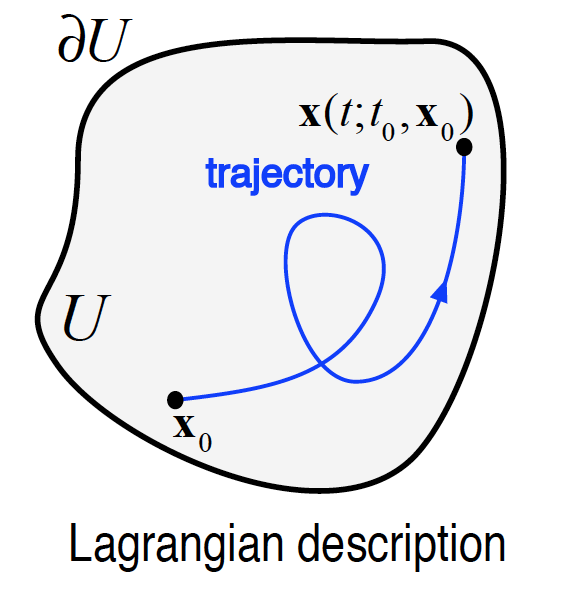 </div> |
|:--:| 
| *fig 2.2* Lagrangian Particle Trajectories |

In [5]:
    def _init_ds(self, *args):

        # time interval [t0, tN]
        self.time = args[0][0]
        
        # Initial time
        self.t0 = self.time[0]

        # Final time
        self.tN = self.time[-1]
        
        # Discrete length of time array
        self.lenT = len(self.time)

        # time step-size
        self.dt = self.time[1]-self.time[0]
        
        # x, y/long, lat coordinates
        self.x_domain = args[0][1]
        self.y_domain = args[0][2]
        
        # define grid spacing
        self.dx = self.x_domain[1]-self.x_domain[0]
        self.dy = self.y_domain[1]-self.y_domain[0]
        
        # Boundaries
        self.xmin = np.min(self.x_domain)
        self.xmax = np.max(self.x_domain)
        self.ymin = np.min(self.y_domain)
        self.ymax = np.max(self.y_domain)
    
        # Meshgrid denoting initial positions
        # from where trajectories are launched at time t0
        self.X_domain, self.Y_domain = np.meshgrid(self.x_domain, self.y_domain)
        
        self.len_X = self.X_domain.shape[1]
        self.len_Y = self.Y_domain.shape[0]
        
        # Specify auxiliary grid
        ratio_aux = args[0][3] 
        self.aux_grid_spacing = [self.dx*ratio_aux, self.dy*ratio_aux]

# Fundamentals of a dynamical system

## Interpolation

We are dealing with a discrete represenation of the velocity field in both space and time. However, in order to compute lagrangian particle trajectories we need to be able to evaluate quantities such as the $ u $ and $ v $ component of the velocity field at any given point in space and time.

### Interpolation of a gridded scalar field

In [6]:
    def _Interpolation(self, Y, X, Field, method = "cubic"):
        
        # kernel used for interpolation in space. 
        # {"cubic", "linear"}
        
        # Cubic interpolation
        if method == "cubic":
                
            kx = 3
            ky = 3
               
        # linear interpolation
        elif method == "linear":
            
            kx = 1
            ky = 1
    
        # import Rectangular bivariate spline from scipy
        from scipy.interpolate import RectBivariateSpline as RBS
        
        return RBS(Y[:,0], X[0,:], Field, kx = kx, ky = ky)

<a id='Interpolation'></a>

### Interpolation of discrete velocity data
As we are dealing with a discrete representation of the velocity-field $ \mathbf{v}(\mathbf{x}, t) $ defined on a domain $ \mathbf{x} \in U $ over the time interval $ [t_0, t_N] $, we seek to generally evaluate the velocity of the particle at arbitrary locations $ \mathbf{x}=\begin{pmatrix} x \\ y \end{pmatrix} \in U $ at times $ t \in [t_0, t_N] $.

The velocity field is reconstructed using rectangular bivariate spline interpolation from the [scipy-library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RBFInterpolator.html). The interpolant can deal with both steady and unsteady 2D velocity fields. For steady velocity fields we avoid interpolating with respect to time. By default the interpolation with respect to time is linear, whereas the interpolation with respect to space can be chosen to be either "linear" or "cubic". The default value for spatial interpolation is "cubic".

In [7]:
    def _Interpolation_velocity(self, method = "cubic"):
    
        # define u, v interpolants
        self.Interpolant_u = []
        self.Interpolant_v = []
            
        # if velocity field is unsteady, then spatial interpolation
        # is computed at each time step.
        if self.boolean_unsteady:    
                    
            for j in range(self.U.shape[2]):
                
                self.Interpolant_u.append(self._Interpolation(self.Y, self.X, self.U[:,:,j], method))
                self.Interpolant_v.append(self._Interpolation(self.Y, self.X, self.V[:,:,j], method))               
        
        # if velocity field is steady, then spatial interpolation
        # is computed only once.
        else:
                    
            self.Interpolant_u.append(self._Interpolation(self.Y, self.X, self.U, method))
            self.Interpolant_v.append(self._Interpolation(self.Y, self.X, self.V, method))

## Differential equation
The method $ \_dxdt $ evaluates the right-hand-side (RHS) of the differential equation given in eq. \ref{eq: dxdt} at (x, t).

Before evaluating the velocity field at *x* at time *t* , the algorithm checks the location of the particle and returns the right indices (*idx_x, idx_y*) of the meshgrid *self.X, self.Y* where the particle is currently located.

If the particle is in a region where the velocity-field is well defined, then we can evaluate the velocity with the method [_velocity_domain](#velocity_domain)

In [8]:
    def _dxdt(self, x, t):
        
        # Check location of lagrangian particle.
        loc, idx_x, idx_y = self._check_location(x)
            
        # If inside defined domain
        # then velocity at (x, t)
        # can be evaluated using the interpolant
        if loc ==  "IN":
            
            return self._velocity_domain(x, t)
                
        elif loc == "BOUNDARY":
            
            return self._velocity_boundary(x, t, idx_x, idx_y)
        
        elif loc == "OUT":
            
            return None

<a id='velocity_domain'></a>
### Velocity in defined domain

The method $ \_velocity\_domain $ computes the velocity of a particle whenever it is in a domain where the velocity field is well defined.

In [9]:
    def _velocity_domain(self, x, t):
            
        # Unsteady case
        if self.boolean_unsteady:
            
            k = int(t/self.dt_data)
            
            # evaluate velocity field at time t
            ui = self.Interpolant_u[k](x[0, 1], x[0, 0])[0][0]
            uf = self.Interpolant_u[k+1](x[0, 1], x[0, 0])[0][0]
            u = ((k+1)*self.dt_data-t)/self.dt_data*ui + (t-k*self.dt_data)/self.dt_data*uf
            
            vi = self.Interpolant_v[k](x[0, 1], x[0, 0])[0][0]
            vf = self.Interpolant_v[k+1](x[0, 1], x[0, 0])[0][0]
            v = ((k+1)*self.dt_data-t)/self.dt_data*vi + (t-k*self.dt_data)/self.dt_data*vf
        
        # Steady case        
        elif self.boolean_unsteady == False:
            
            u = self.Interpolant_u(x[0, 1], x[0, 0])[0][0]
            v = self.Interpolant_v(x[0, 1], x[0, 0])[0][0]
        
        vel = np.array([u, v])
        
        return vel

### Velocity on boundary

The method $ \_velocity\_boundary $ computes the velocity of a particle in proximity of a solid boundary (e.g. wall/land). We thereby assume a no-slip boundary condition.

At the boundary, the interpolant computed in section [3.1 Interpolation of discrete velocity data](#Interpolation) is not well defined anymore as it extrapolates into a region where the velocity field is undefined. Especially "cubic" interpolation methods lead to strong overshooting at the boundary of the defined velocity domain. Hence, computing the velocity at the boundary using the method [_velocity_domain](#velocity_domain) leads to unphysical lagrangian particle trajectories as it would violate boundary conditions (Lagrangian particle cannot penetrate the wall or hit the land).

In [10]:
    def _velocity_boundary(self, x, t, idx_x, idx_y):
                
        check_idx = (idx_x < self.defined_domain.shape[1] - 1) and (idx_y < self.defined_domain.shape[0] - 1)
        
        x_p = x[0, 0]
        y_p = x[0, 1]
        
        left_boundary = np.sum(self.defined_domain[idx_y-1:idx_y+1, idx_x]) == 2 and np.sum(self.defined_domain[idx_y-1:idx_y+1, idx_x-1]) == 0
        right_boundary = np.sum(self.defined_domain[idx_y-1:idx_y+1, idx_x]) == 0 and np.sum(self.defined_domain[idx_y-1:idx_y+1, idx_x-1]) == 2
        upper_boundary = np.sum(self.defined_domain[idx_y-1,idx_x-1:idx_x+1]) == 2 and np.sum(self.defined_domain[idx_y,idx_x-1:idx_x+1]) == 0
        lower_boundary = np.sum(self.defined_domain[idx_y-1,idx_x-1:idx_x+1]) == 0 and np.sum(self.defined_domain[idx_y,idx_x-1:idx_x+1]) == 2
        
        
        # left/right boundary 
        if left_boundary or right_boundary:
            
            if left_boundary:
            
                x_wall = self.X[0, idx_x-1]
                    
                x_boundary_layer = np.array([[self.X[0, idx_x], x[0,1]]])
            
            elif right_boundary:
                
                x_wall = self.X[0, idx_x]
                    
                x_boundary_layer = np.array([[self.X[0, idx_x-1], x[0,1]]])
                
            vel = self._velocity_domain(x_boundary_layer, t)
                    
            x_tilde = np.abs(x[0,0]-x_wall)
                    
            u = vel[0]*(x_tilde/self.dx_data)**2
            v = vel[1]*(x_tilde/self.dx_data)
            
        # upper/lower boundary
        elif upper_boundary or lower_boundary:
            
            if upper_boundary:
        
                y_wall = self.Y[idx_y, 0]
                                
                x_boundary_layer = np.array([[x[0,0], self.Y[idx_y-1, 0]]])
            
            elif lower_boundary:
                
                y_wall = self.Y[idx_y-1, 0]
                
                x_boundary_layer = np.array([[x[0,0], self.Y[idx_y, 0]]])
                    
            vel = self._velocity_domain(x_boundary_layer, t)
                                  
            y_tilde = np.abs(y_wall-x[0,1])
                    
            u = vel[0]*(y_tilde/self.dy_data)
            v = vel[1]*(y_tilde/self.dy_data)**2
            
        elif np.sum(self.defined_domain[idx_y-1:idx_y+1, idx_x-1:idx_x+1]) == 1:
            
            if self.defined_domain[idx_y-1, idx_x-1] or self.defined_domain[idx_y, idx_x]:
            
                wall_orientation = np.array([-1, 1])
            
                thickness = np.sqrt(self.dx_data**2+self.dy_data**2)/2
            
                y_0 = self.Y[idx_y, idx_x-1]
                x_0 = self.X[idx_y, idx_x-1]
            
                x_wall = ((y_0-y_p)+x_p+x_0)/2
                y_wall = ((y_0+y_p)+(x_0-x_p))/2
                
                if self.defined_domain[idx_y-1, idx_x-1]:
            
                    x_boundary_layer = np.array([[x_wall - thickness/np.sqrt(2), y_wall - thickness/np.sqrt(2)]])
            
                elif self.defined_domain[idx_y, idx_x]:
                    
                    x_boundary_layer = np.array([[x_wall + thickness/np.sqrt(2), y_wall + thickness/np.sqrt(2)]])
                
                vel = self._velocity_domain(x_boundary_layer, t)
            
                # Coordinate transformation
            
                y_tilde = np.sqrt((x_wall-x_p)**2+(y_wall-y_p)**2)
            
                u_new = (-vel[0]+vel[1])/np.sqrt(2)*(y_tilde/thickness)
                v_new = (-vel[0]-vel[1])/np.sqrt(2)*(y_tilde/thickness)**2
            
                u = -(u_new+v_new)/np.sqrt(2)
                v = (u_new-v_new)/np.sqrt(2)
                
            elif self.defined_domain[idx_y, idx_x-1] or self.defined_domain[idx_y - 1, idx_x]:
            
                wall_orientation = np.array([1, 1])
            
                thickness = np.sqrt(self.dx_data**2+self.dy_data**2)/2
            
                y_0 = self.Y[idx_y-1, idx_x-1]
                x_0 = self.X[idx_y-1, idx_x-1]
            
                x_wall = ((y_0-y_p)+x_p+x_0)/2
                y_wall = ((y_0+y_p)+(x_0-x_p))/2
                
                if self.defined_domain[idx_y, idx_x-1]:
            
                    x_boundary_layer = np.array([[x_wall - thickness/np.sqrt(2), y_wall + thickness/np.sqrt(2)]])
            
                elif self.defined_domain[idx_y-1, idx_x]:
                    
                    x_boundary_layer = np.array([[x_wall + thickness/np.sqrt(2), y_wall - thickness/np.sqrt(2)]])
            
                vel = self._velocity_domain(x_boundary_layer, t)
            
                # Coordinate transformation
            
                y_tilde = np.sqrt((x_wall-x_p)**2+(y_wall-y_p)**2)
            
                u_new = (vel[0]+vel[1])/np.sqrt(2)*(y_tilde/thickness)
                v_new = (-vel[0]+vel[1])/np.sqrt(2)*(y_tilde/thickness)**2
            
                u = (u_new-v_new)/np.sqrt(2)
                v = (u_new+v_new)/np.sqrt(2)                   
        
        elif np.sum(self.defined_domain[idx_y-1:idx_y+1, idx_x-1:idx_x+1]) == 3 and check_idx:
            
            x_p = x[0, 0]
            y_p = x[0, 1]
            
            if check_idx:
            
                diag_1 = np.sum(self.defined_domain[idx_y+1, idx_x-1]+self.defined_domain[idx_y, idx_x]+self.defined_domain[idx_y-1, idx_x+1]) == 0
                diag_2 = np.sum(self.defined_domain[idx_y-1, idx_x-1]+self.defined_domain[idx_y, idx_x]+self.defined_domain[idx_y+1, idx_x+1]) == 0 
            
                if diag_1:
                
                    wall_orientation = np.array([-1, 1])
                    thickness = np.sqrt(self.dx_data**2+self.dy_data**2)/2
            
                    y_0 = self.Y[idx_y+1, idx_x-1]
                    x_0 = self.X[idx_y+1, idx_x-1]
            
                    x_wall = ((y_0-y_p)+x_p+x_0)/2
                    y_wall = ((y_0+y_p)+(x_0-x_p))/2
                
                    if np.sum(self.defined_domain[idx_y, idx_x-1]+self.defined_domain[idx_y-1, idx_x-1]+self.defined_domain[idx_y-1, idx_x]) == 3:
                
                        x_boundary_layer = np.array([[x_wall - thickness/np.sqrt(2), y_wall - thickness/np.sqrt(2)]])
        
                        if y_p+x_p < x_boundary_layer[0,0] + x_boundary_layer[0,1]:
                
                            vel = self._velocity_domain(x, t)
                    
                            return vel
        
                    elif np.sum(self.defined_domain[idx_y+1, idx_x+1]+self.defined_domain[idx_y, idx_x+1]+self.defined_domain[idx_y+1, idx_x]) == 3:
                
                        x_boundary_layer = np.array([[x_wall + thickness/np.sqrt(2), y_wall + thickness/np.sqrt(2)]])
        
                        if y_p+x_p > x_boundary_layer[0,0] + x_boundary_layer[0,1]:
                
                            vel = self._velocity_domain(x, t)
                    
                            return vel
            
                    else:
            
                        return None
            
                    vel = self._velocity_domain(x_boundary_layer, t)
            
                    y_tilde = np.sqrt((x_wall-x_p)**2+(y_wall-y_p)**2)
            
                    # Velocity in coordinates parallel to diagonal boundary transformation
            
                    u_new = (-vel[0]+vel[1])/np.sqrt(2)*(y_tilde/thickness)
                    v_new = (-vel[0]-vel[1])/np.sqrt(2)*(y_tilde/thickness)**2
            
                    u = -(u_new+v_new)/np.sqrt(2)
                    v = (u_new-v_new)/np.sqrt(2)
        
                elif diag_2 == 0: 
            
                    wall_orientation = np.array([1, 1])
                    thickness = np.sqrt(self.dx_data**2+self.dy_data**2)/2
            
                    y_0 = self.Y[idx_y-1, idx_x-1]
                    x_0 = self.X[idx_y-1, idx_x-1]
            
                    x_wall = ((y_p-y_0)+x_p+x_0)/2
                    y_wall = ((y_p+y_0)+x_p-x_0)/2
            
                    if np.sum(self.defined_domain[idx_y+1, idx_x-1]+self.defined_domain[idx_y, idx_x-1]+self.defined_domain[idx_y+1, idx_x]) == 3:
            
                        x_boundary_layer = np.array([[x_wall - thickness/np.sqrt(2), y_wall + thickness/np.sqrt(2)]])
                
                        if y_p-x_p > x_boundary_layer[0,1] - x_boundary_layer[0,0]:
                
                            vel = self._velocity_domain(x, t)
                    
                            return vel
                    
                    elif np.sum(self.defined_domain[idx_y-1, idx_x+1]+self.defined_domain[idx_y-1, idx_x]+self.defined_domain[idx_y, idx_x+1]) == 3:
                    
                        x_boundary_layer = np.array([[x_wall + thickness/np.sqrt(2), y_wall - thickness/np.sqrt(2)]])
            
                        if y_p-x_p < x_boundary_layer[0,1] - x_boundary_layer[0,0]:
                
                            vel = self._velocity_domain(x, t)
                    
                            return vel
                    
                    else:
                        
                        return None
                    
                    vel = self._velocity_domain(x_boundary_layer, t)
            
                    # Coordinate transformation 
                    y_tilde = np.sqrt((x_wall-x_p)**2+(y_wall-y_p)**2)
            
                    u_new = (vel[0]+vel[1])/np.sqrt(2)*(y_tilde/thickness)
                    v_new = (-vel[0]+vel[1])/np.sqrt(2)*(y_tilde/thickness)**2
            
                    u = (u_new-v_new)/np.sqrt(2)
                    v = (u_new+v_new)/np.sqrt(2)
                
        else:
            
            return None
    
        vel = np.array([u, v])
        
        return vel

## Lagrangian particle trajectories

### $4^{th}$-order Runge Kutta integration

In [11]:
    def _RK4(self, x, t, dt):
    
        # Define starting point.
        x1 = x
        t1 = t
        
        vel = True
        
        # If x is outside defined domain --> vel is None --> _RK4 returns "None" and integration will stop.
        while vel is not None:
    
            # Compute velocity at the beginning of the time-step
            vel = self._dxdt(x1, t1)
            if vel is None: break      
            k1 = dt * vel
    
            # Update position and time at the first midpoint.
            x2 = x1 + .5 * k1
            t2 = t + .5 * dt
    
            # Compute velocity at the first midpoint.
            vel = self._dxdt(x2, t2)
            if vel is None: break
            k2 = dt * vel

            # Update position and time at the second midpoint.
            x3 = x1 + .5 * k2
            t3 = t + .5 * dt
    
            # Compute velocity at the second midpoint.
            vel = self._dxdt(x3, t3)
            if vel is None: break
            k3 = dt * vel
    
            # Update position and time at the first midpoint.
            x4 = x1 + k3
            if vel is None: break
            t4 = t + dt
    
            # Compute velocity at the end of the time-step.
            vel = self._dxdt(x4, t4)
            if vel is None: break
            k4 = dt * vel
    
            # define list for velocity and positions of particle
            vel_update = []
            x_update = []
        
            # Compute velocity
            for j in range(self.dim):
                # Update velocity of particles
                vel_update.append(1.0 / 6.0*(k1[j] + 2 * k2[j] + 2 * k3[j] + k4[j])/dt)
    
            # Integration x <-- x + v*dt
            for j in range(self.dim):
                # Update position of particles
                x_update.append(x[0,j] + vel_update[j]*dt)
    
            vel_update = np.array(vel_update).reshape(1, -1)
            x_update = np.array(x_update).reshape(1, -1)
    
            return x_update, vel_update
        
        return None, None

### Single Lagrangian particle trajectories

In [12]:
    def _trajectory(self, x, time):
        
        # Initialize trajectory array.
        trajectory = np.zeros((len(time), 2))
        
        # Initialize velocity array
        velocity = np.zeros((len(time), 2))
        
        dt = time[1]-time[0]
    
        # Integration of trajectory using RK4
        for i, t in enumerate(time):
            
            trajectory[i,:] = x[0, :]
        
            # Integrate using 4th-order Runge-Kutta.                     
            x, vel = self._RK4(x, t, dt)
        
            # Periodic boundary conditions.
            if self.periodic[0]:
                
                if x[0, 0] > self.xmax or x[0, 0] < self.xmin:
                
                    x[0, 0] = ((x[0, 0]-self.xmin) % (self.xmax-self.xmin))+self.xmin
                
            if self.periodic[1]:
                
                if x[0, 1] > self.ymax or x[0, 1] < self.ymin:
                
                    x[0, 1] = ((x[0, 1]-self.ymin) % (self.ymax-self.ymin))+self.ymin
            
            # If x is "None"
            # Trajectory outside of defined domain --> STOP INTEGRATION
            # Set velocity/trajectory to np.nan
            if x is None:
                #Trajectory is nan!!!
                trajectory[:, :] = np.nan
                velocity[:, :] = np.nan
                break
                                
            velocity[i, :] = vel[0, :]
                
        return trajectory.T, velocity.T

### Lagrangian particle trajectories on a grid

In [13]:
    def _trajectory_grid(self):
        
        print("=================Trajectories over meshgrid=================")
        
        def parallelization(i):
            
            trajectories = np.zeros((self.len_X, self.dim, len(self.time)))
            velocities = np.zeros((self.len_X, self.dim, len(self.time)))
            
            for j in range(self.len_X):
                                          
                x = np.array([[self.X_domain[i, j], self.Y_domain[i, j]]])
                    
                trajectories[j, :, :], velocities[j, :, :] = self._trajectory(x, self.time)
                
            return trajectories, velocities
        
        res = Parallel(n_jobs=self.Ncores, verbose = 1)(delayed(parallelization)(i) for i in tqdm(range(self.len_Y)))
        
        self.trajectory_grid = np.array(res)[:,0,:,:,:]
        self.velocity_grid = np.array(res)[:,1,:,:,:-1]

### Flow map

In [14]:
    def _Fmap(self, x, time):
    
        x = self._trajectory(x, time)
    
        F_t0_tN = x[:, -1].reshape(1, -1)
    
        return F_t0_tN

# Tensors and gradients

## Gradient of the flow map

### $ \nabla F_{t_0}^{t_N} $

In [15]:
    def _grad_Fmap(self, x, time):
    
        # Initialized gradient of flow map
        grad_Fmap = np.zeros((self.dim, self.dim))
    
        # Array containing vectors for grid-spacing
        delta_aux = np.diag(self.aux_grid_spacing)
    
        for i in range(self.dim):
            for j in range(self.dim):            
                x_aux0 = x-delta_aux[i, :]
                x0 = self._Fmap(x_aux0, time)
                x_aux1 = x-delta_aux[i, :]
                x1 = self._Fmap(x_aux1, time)
                grad_Fmap[i, j] = (x1[0, j]-x0[0, j])/(2*delta_aux[i, i])
    
        return grad_Fmap

### Gradient of the flow map using auxiliary grid

In [16]:
    def _grad_Fmap_aux_grid(self):
                                 
        self.grad_Fmap_grid = np.zeros((self.len_Y, self.len_X, self.dim, self.dim))
        
        for i in range(self.len_Y):
                
            for j in range(self.len_X):
    
                x = np.array([[self.X_domain[i, j], self.Y_domain[i, j]]])
                        
                self.grad_Fmap_grid[i, j, :, : ] = self._grad_Fmap(x, self.time)
            
        return self.grad_Fmap_grid

### Gradient of the flow map over a meshgrid.

In [17]:
    def _grad_Fmap_grid(self, aux_grid = False):
        
        if aux_grid == False:
            
            if hasattr(self, 'trajectory_grid') == False:
                
                self._trajectory_grid()
        
            print("=================gradient of Flow map w/ meshgrid=================")
        
            Fmap_grid = np.zeros((self.len_Y, self.len_X, self.dim))
            
            self.grad_Fmap_grid = np.zeros((self.len_Y, self.len_X, self.dim, self.dim))
    
            for i in range(self.len_Y):
        
                for j in range(self.len_X):
                    
                    Fmap_grid[i, j, :] = self.trajectory_grid[i, j, :, -1]
            
            for i in range(1, self.len_Y-1):
                
                for j in range(1, self.len_X-1):
                    
                    for c in range(self.dim):
                        
                        self.grad_Fmap_grid[i, j, c, 0] = (Fmap_grid[i, j+1, c] - Fmap_grid[i, j-1, c])/(2*self.dx)
                        self.grad_Fmap_grid[i, j, c, 1] = (Fmap_grid[i+1, j, c] - Fmap_grid[i-1, j, c])/(2*self.dy)
                        
        else:
            
            print("=================gradient of Flow map w/ auxiliary grid=================")
            
            def parallelization(i):
                
                grad_Fmap = np.zeros((self.len_X, self.dim, self.dim))
                
                for j in range(self.len_X):
                    
                    x = np.array([[self.X_domain[i, j], self.Y_domain[i, j]]])
                
                    grad_Fmap[j, :, :] = self._grad_Fmap_aux_grid(x, self.time)
                
                return grad_Fmap
            
            self.grad_Fmap_grid = np.array(Parallel(n_jobs=self.Ncores)(delayed(parallelization)(i) for i in tqdm(range(self.len_Y))))
            
        return self.grad_Fmap_grid

## Cauchy-green-strain tensor

In [18]:
    def _cauchy_green_strain(self):
        
        if hasattr(self, 'grad_Fmap_grid') == False:
                  
            self._grad_Fmap_grid()
            
        print("=================Cauchy-Green-Strain tensors=================")
            
        self.B = np.zeros((self.len_Y, self.len_X, self.dim, self.dim))
        self.C = self.B.copy()
            
        for i in range(self.len_Y):
                
            for j in range(self.len_X):
                    
                ### Compute left Cauchy-Green-Strain tensor
                self.B[i, j, :, :] = np.dot(self.grad_Fmap_grid[i, j, :, :], self.grad_Fmap_grid[i, j, :, :].transpose())
                    
                ### Compute right Cauchy-Green-Strain tensor
                self.C[i, j, :, :] = np.dot(self.grad_Fmap_grid[i, j, :, :].transpose(), self.grad_Fmap_grid[i, j, :, :])
                    
        return self.B, self.C

## Gradient of velocity

In [19]:
    def _grad_vel(self, x, t):
        
        x = x.reshape(1, -1)
        
        grad_vel = np.zeros((self.dim, self.dim))
        
        delta_aux = np.diag(self.aux_grid_spacing)
        
        for i in range(self.dim):
            
            for j in range(self.dim):          
                
                x_aux0 = x-delta_aux[i, :]
                v0 = self._dxdt(x_aux0, t)
                
                x_aux1 = x+delta_aux[i, :]
                v1 = self._dxdt(x_aux1, t)
                
                if v1 is None or v0 is None:
                    
                    grad_vel[i, j] = np.nan
                    
                else:
                
                    grad_vel[i, j] = (v1[j]-v0[j])/(2*delta_aux[i, i])
                
        return grad_vel

## Vorticity tensor

In [20]:
    def _vorticity_tensor(self, x, t):
        
        grad_vel = self._grad_vel(x, t)
    
        return .5*(grad_vel-grad_vel.T)

## Spin tensor

In [21]:
    def _spin_tensor(self, x, t):
        
        grad_vel = self._grad_vel(x)
        
        return .5*(grad_vel+grad_vel.T)

# General Functions

In [22]:
    def _ocean_velocity_units(self, y0, u_ms, v_ms):
        
        earthRadius = 6371*(10**3)
        
        u_deg = (u_ms / (np.cos(y0*(np.pi/180))*(earthRadius)))*180*3600*24/np.pi
        v_deg = (v_ms /earthRadius)*180*3600*24/np.pi
        
        return u_deg, v_deg

## Check position of particle
The method $\_check\_location$ checks if the point $ x $ is in a domain where the velocity field is defined.

In [23]:
    def _check_location(self, x):
        
        xp = x[0, 0]
        yp = x[0, 1]
        
        idx_x = np.searchsorted(self.X[0,:], xp)
        idx_y = np.searchsorted(self.Y[:,0], yp)
        
        if xp < self.X[0, 0] or xp > self.X[0,-1] or yp < self.Y[0, 0] or yp > self.Y[-1, 0]:
            
            loc = "OUT"
            
            return loc, idx_x, idx_y
        
        else:
            
            Condition_nan = np.sum(self.defined_domain[idx_y-1:idx_y+1, idx_x-1:idx_x+1].ravel())
        
            if Condition_nan == 4:
        
                loc = "IN"
                    
            elif Condition_nan == 0:
            
                loc = "OUT"
        
            elif Condition_nan == 2:
            
                loc = "BOUNDARY"
                
            elif Condition_nan == 1:
                
                if self.defined_domain[idx_y-1, idx_x-1]:
                    
                    if idx_y == self.defined_domain.shape[0]-1 and idx_x == self.defined_domain.shape[1]-1:
                        
                        loc = "OUT"
                    
                    else:
                        
                        if x[0, 1] + x[0, 0] < self.Y[idx_y, idx_x-1] + self.X[idx_y, idx_x-1]:
                        
                            loc = "BOUNDARY"
                        
                        else:
                        
                            loc = "OUT"
                        
                elif self.defined_domain[idx_y, idx_x]:
                    
                    if idx_y == 1 and idx_x == 1:
                    
                        loc = "OUT"
                    
                    else:
                    
                        if x[0, 1] + x[0, 0] > self.Y[idx_y, idx_x-1] + self.X[idx_y, idx_x-1]:
                        
                            loc = "BOUNDARY"
                        
                        else:
                        
                            loc = "OUT"
                        
                elif self.defined_domain[idx_y, idx_x-1]:
                    
                    if idx_y == 1 and idx_x == self.defined_domain.shape[1]-1:
                        
                        loc = "OUT"
                    
                    else:
                        
                        if x[0, 1] - x[0, 0] < self.Y[idx_y-1, idx_x-1] - self.X[idx_y-1, idx_x-1]:
                        
                            loc = "BOUNDARY"
                        
                        else:
                        
                            loc = "OUT"
                        
                elif self.defined_domain[idx_y-1, idx_x]:
                    
                    if idx_y == self.defined_domain.shape[0]-1 and idx_x == 1:
                    
                        loc = "OUT"
                    
                    else:
                    
                        if x[0, 1] - x[0, 0] > self.Y[idx_y-1, idx_x-1] - self.X[idx_y-1, idx_x-1]:
                        
                            loc = "BOUNDARY"
                        
                        else:
                        
                            loc = "OUT"
                        
            elif Condition_nan == 3:
                
                loc = "BOUNDARY"
                    
                
        return loc, idx_x, idx_y

## Eigenvalue and Eigenvectors

In [24]:
    def _eigenvalues_and_eigenvectors(self, A):
                   
        a = A[0,0]
        b = A[0,1]
        c = A[1,0]
        d = A[1,1]
            
        lamda_max = (a+d)/2+np.sqrt((a+d)**2/4-(a*d-b*c))
        
        if self.incompressible:
            
            if lamda_max < 1:
                
                lamda_max = np.nan
        
            lamda_min = 1/lamda_max
            
        else:
            
            lamda_min = (a+d)/2-np.sqrt((a+d)**2/4-(a*d-b*c))
        
        if np.abs((a+d)**2/4-(a*d-b*c)) <= 10**(-14):
                       
            if b == 0 and c == 0:
            
                v_max = np.array([1, 0])
                v_min = np.array([0, 1])
                
            elif b != 0 and c == 0:
                
                v_max = np.array([1, 0])
                v_min = np.array([np.nan, np.nan])
                
            elif b == 0 and c != 0:
                
                v_max = np.array([0, -1])
                v_min = np.array([np.nan, np.nan])
            
            else:
                
                v_max = np.array([-b, a-lamda_max])
                v_max = v_max/np.sqrt(v_max[0]**2+v_max[1]**2)
            
                v_min = np.array([-b, a-lamda_min])
                v_min = v_min/np.sqrt(v_min[0]**2+v_min[1]**2)
            
        else:
        
            if a-lamda_max != 0 and b != 0:
            
                v_max = np.array([-b, a-lamda_max])
                v_max = v_max/np.sqrt(v_max[0]**2+v_max[1]**2)
            
                v_min = np.array([-b, a-lamda_min])
                v_min = v_min/np.sqrt(v_min[0]**2+v_min[1]**2)
        
            else:
            
                v_max = np.array([d-lamda_max, -c])
                v_max = v_max/np.sqrt(v_max[0]**2+v_max[1]**2)
            
                v_min = np.array([d-lamda_min, -c])
                v_min = v_min/np.sqrt(v_min[0]**2+v_min[1]**2)
                        
        return lamda_min, lamda_max, v_min, v_max

## Singular value decomposition

In [25]:
    def _svd(self, A):  
            
        U, S, V = np.linalg.svd(A)
                        
        return U, S, V